## Summary for paper



### Learning rate engineering

Regarding learning rate, all the training attempts have basic learning rate $blr$.

- When using Adam optimizer as default, use basic learning rate as is.
- When fine tuning, use Adam with learning rate $blr \times 0.1$.
- When using cyclic LR, use $blr$ as lower bound learning rate and $blr \times 10$ as upper bound of cycle.

### Augmentation methods & cyclic LR results

|#| Combination | CLR | RandomErasing | Mixup| Public LB |Delta from basemodel | Saturated Train Acc@Epoch|Best Valid Acc@Epoch|
|:-:|:--------|:---:|:-------------:|:----:|:---------|:----------|:----------|:---------------------|:----------|
|1|basemodel| No | No | No | 0.75333|0.0|0.9387@44|0.73864@18|
|2|basemodel+CLR| Yes | No | No | 0.72133|-0.032|0.9348@59|0.74919@26|
|3|basemodel+RandomErasing| No | Yes | No | 0.75466|+0.00133|0.9831@106|0.79464@66|
|4|basemodel+Mixup| No | No | Yes | 0.76266|+0.00933|Training Not Saturated|0.81088@132|
|5|basemodel+All but CLR| No | Yes | Yes | 0.76400|+0.01067|Training Not Saturated|0.81494@216|
|6|basemodel+All| Yes | Yes | Yes | 0.77066|+0.01733|Training Not Saturated|0.81250@126|

- Without enough augmentation, training will saturate (1-3).
- Without good optimizer, training augmented data is difficult (4-5).
- Combining strong augmentation with strong optimizer (this time it is Adam + Cyclic learning rate) can improve performance.

### Single results for all approaches

All following results is with CLR, RandomErasing, Mixup and Fine tuning.

| Approach     |      Description    | Model     | Public LB |
|:------------|:---------------------|:----------|:----------|
|basemodel    | Simple 40x501 image classifier |AlexNet|0.77066|
|timewise-mean| Timewise mean 40x1 classifier that completely ignore temporal change of sound |CNN5|0.75200|
|event-pattern| A classifier that focuses on temporal change of sound by subtracting background sound|CNN7|0.70000|
|event-pattern/ alexnet| Same as above, but with different model|AlexNet|0.71466|

### Ensemble results

| Ensemble summary | Base model | Event Pattern | Event Pattern/AlexNet| Timewise mean | Public LB |Delta from basemodel|
|:-----------------|:----------:|:-------------:|:--------------------:|:-------------:|:---------:|:---------:|
| Base model only  | Yes        | No            | No             | No             | 0.77066   |0.0|
| + Time-wise mean | Yes  | No            | No             | Yes            | 0.77600   |+0.00534|
| + Event Pattern  | Yes  | Yes           | No             | No             | 0.81600   |+0.04534|
| + Event Pattern/ AlexNet| Yes  | No       | Yes            | No             | 0.81200   |+0.04134|
| Ensemble All     | Yes        | Yes           | Yes            | Yes            | 0.84133   |+0.07067|

Ensemble of 4 approaches improved about 7% from use of single base model.


## All results

| Summary | CLR | RandomErasing | Mixup | Fine tune | Approach | Public LB |Saturated Train Acc@Epoch|Best Valid Acc@Epoch|
|:--------|:---:|:-------------:|:-----:|:---------:|:---------|:----------|:----------|:----------|
|basemodel| No | No | No | No | Use dataset as is |0.72000|0.9960@131|0.78409@200|
|basemodel+FineTune| No | No | No | Yes | Use dataset as is |0.75733|--|--|
|basemodel+CLR| Yes | No | No | No | Use dataset as is |0.72533|0.9881@126|0.76136@66|
|basemodel+CLR+FineTune| Yes | No | No | Yes | Use dataset as is |0.74000|--|--|
|basemodel+RandomErasing| No | Yes | No | No | Use dataset as is |0.72533|0.9831@106|0.79464@66|
|basemodel+RandomErasing+FineTune| No | Yes | No | Yes | Use dataset as is |0.75466|--|--|
|basemodel+Mixup| No | No | Yes | No | Use dataset as is |0.74800|Training Not Saturated|0.81088@132|
|basemodel+Mixup+FineTune| No | No | Yes | Yes | Use dataset as is |0.76266|--|--|
|basemodel+All but CLR| No | Yes | Yes | Yes | Use dataset as is |0.76400|Training Not Saturated|0.81494@216|
|basemodel+All| Yes | Yes | Yes | Yes | Use dataset as is |0.77066|Training Not Saturated|0.81250@126|
|timewise-mean| Yes | Yes | Yes | Yes | Time-wise mean 40x1 |0.75200|Training Not Saturated|0.78247@436|
|event-pattern| Yes | Yes | Yes | Yes | Pseudo bg subtraction|0.70000|Training Not Saturated|0.74188@446|
|event-pattern/alexnet | Yes | Yes | Yes | Yes | Same as above, but with AlexNet|0.71466|Training Not Saturated|0.76542@324|



| Ensemble summary | Base model | Event Pattern | Event Pattern/AlexNet| Timewise mean | Mean      | Public LB |
|:-----------------|:----------:|:-------------:|:--------------------:|:-------------:|:---------:|:---------:|
| Base model only  | Yes        | No            | No                   | No            | N/A       | 0.77066   |
| All by arithmetic mean | Yes  | Yes           | Yes                  | Yes           | Arithmetic| 0.84133   |
| Base + Event Pattern   | Yes  | Yes           | No                   | No            | Arithmetic| 0.80933   |
| Base + Event Pattern/AlexNet   | Yes  | No    | Yes                  | No            | Arithmetic| 0.81200   |
| Base + Time-wise mean  | Yes  | No            | No                   | Yes           | Arithmetic| 0.77600   |
| All by geometric mean  | Yes  | Yes           | Yes                  | Yes           | Geometric | 0.84133   |
| Base + Event Pattern   | Yes  | Yes           | No                   | No            | Geometric | 0.81600   |
| Base + Event Pattern/AlexNet   | Yes  | No    | Yes                  | No            | Geometric | 0.81200   |
| Base + Time-wise mean  | Yes  | No            | No                   | Yes           | Geometric | 0.77600   |


In [2]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('common')
sys.path.append('external')
import util
from domain_modules import *
from domain_models import *

import keras
import keras.backend as K
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation, Dropout, BatchNormalization, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, TensorBoard

DATAROOT = os.path.join(os.path.expanduser('~'), '.kaggle/competitions/acoustic-scene-2018')

Using TensorFlow backend.


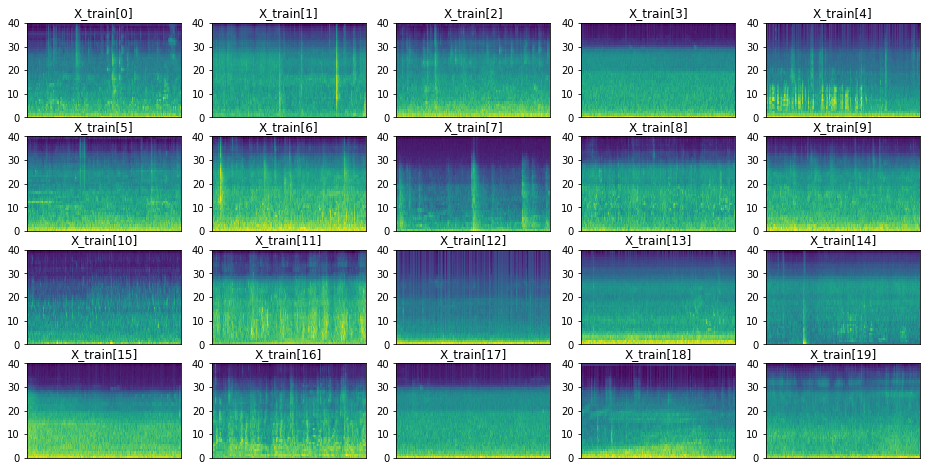

In [3]:
d = Dataset(DATAROOT)
plot_data(d.X_train, 'X_train[%d]')

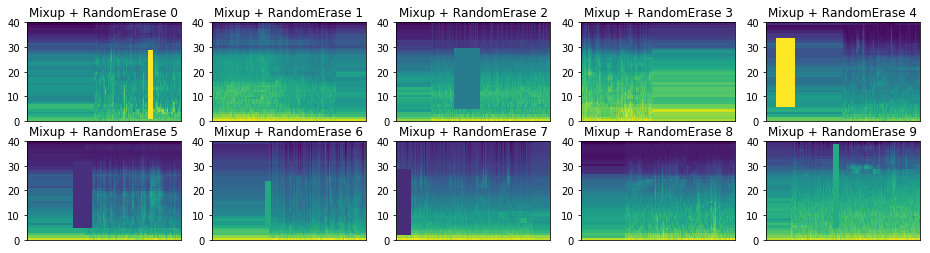

[[ 0.8466509   0.          0.1533491   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.69911601  0.          0.          0.          0.          0.          0.
   0.          0.          0.30088399  0.          0.          0.          0.
   0.        ]]


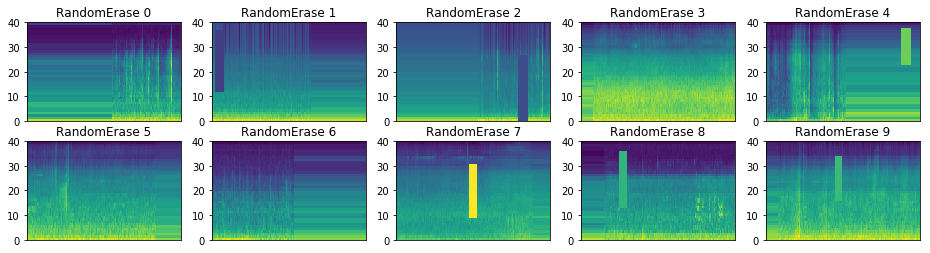

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


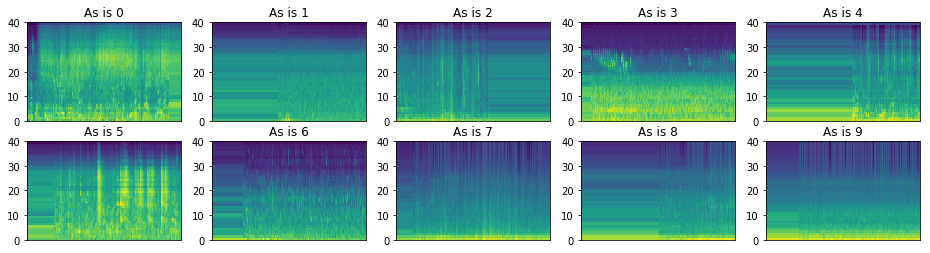

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [5]:
train_flow, valid_flow, test_flow, _, _ = get_datagen(d, batch_size=32, use_random_eraser=True, use_mixup=True)
X, y = next(train_flow)
plot_data(X, 'Mixup + RandomErase %d', N=10)
print(y[:2])
train_flow, valid_flow, test_flow, _, _ = get_datagen(d, batch_size=32, use_random_eraser=True, use_mixup=False)
X, y = next(train_flow)
plot_data(X, 'RandomErase %d', N=10)
print(y[:2])
train_flow, valid_flow, test_flow, _, _ = get_datagen(d, batch_size=32, use_random_eraser=False, use_mixup=False)
X, y = next(train_flow)
plot_data(X, 'As is %d', N=10)
print(y[:2])

In [9]:
model = model_cnn_alexnet(d.X_train.shape[1:], d.num_classes, lr=0.0001)
trainer = Trainer('basemodel', d, model, 0.0001, 200, 32,
                  use_cyclic_lr=False, use_random_eraser=False, use_mixup=False)
trainer.fit()

not using cyclic lr
Epoch 1/200
101/102 [============================>.] - ETA: 0s - loss: 2.7932 - acc: 0.1507
Epoch 00001: val_acc improved from -inf to 0.32955, saving model to basemodel/best.h5
102/102 [==============================] - 4s 36ms/step - loss: 2.7888 - acc: 0.1501 - val_loss: 2.0553 - val_acc: 0.3295
Epoch 2/200
101/102 [============================>.] - ETA: 0s - loss: 2.2383 - acc: 0.2695
Epoch 00002: val_acc did not improve
102/102 [==============================] - 3s 29ms/step - loss: 2.2390 - acc: 0.2699 - val_loss: 1.9767 - val_acc: 0.3271
Epoch 3/200
100/102 [============================>.] - ETA: 0s - loss: 2.0155 - acc: 0.3350
Epoch 00003: val_acc improved from 0.32955 to 0.46104, saving model to basemodel/best.h5
102/102 [==============================] - 3s 29ms/step - loss: 2.0100 - acc: 0.3367 - val_loss: 1.6532 - val_acc: 0.4610
Epoch 4/200
101/102 [============================>.] - ETA: 0s - loss: 1.7997 - acc: 0.3988
Epoch 00004: val_acc improved from

101/102 [============================>.] - ETA: 0s - loss: 0.3656 - acc: 0.8787
Epoch 00031: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.3659 - acc: 0.8784 - val_loss: 1.3964 - val_acc: 0.7127
Epoch 32/200
 99/102 [============================>.] - ETA: 0s - loss: 0.3208 - acc: 0.8958
Epoch 00032: val_acc improved from 0.72078 to 0.72646, saving model to basemodel/best.h5
102/102 [==============================] - 3s 27ms/step - loss: 0.3193 - acc: 0.8971 - val_loss: 1.0889 - val_acc: 0.7265
Epoch 33/200
101/102 [============================>.] - ETA: 0s - loss: 0.3367 - acc: 0.8933
Epoch 00033: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.3401 - acc: 0.8922 - val_loss: 1.2315 - val_acc: 0.7200
Epoch 34/200
100/102 [============================>.] - ETA: 0s - loss: 0.3033 - acc: 0.9059
Epoch 00034: val_acc did not improve
102/102 [==============================] - 3s 29ms/step - loss: 0.3003 - ac

Epoch 63/200
100/102 [============================>.] - ETA: 0s - loss: 0.1443 - acc: 0.9537
Epoch 00063: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1452 - acc: 0.9534 - val_loss: 1.4819 - val_acc: 0.7265
Epoch 64/200
100/102 [============================>.] - ETA: 0s - loss: 0.1081 - acc: 0.9666
Epoch 00064: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1086 - acc: 0.9666 - val_loss: 1.7289 - val_acc: 0.7086
Epoch 65/200
101/102 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9595
Epoch 00065: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1340 - acc: 0.9575 - val_loss: 1.7631 - val_acc: 0.7037
Epoch 66/200
100/102 [============================>.] - ETA: 0s - loss: 0.1141 - acc: 0.9656
Epoch 00066: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1126 - acc: 0.9660 - val_loss: 1.6576 - val_acc:

Epoch 96/200
101/102 [============================>.] - ETA: 0s - loss: 0.0869 - acc: 0.9759
Epoch 00096: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0863 - acc: 0.9761 - val_loss: 1.8948 - val_acc: 0.6818
Epoch 97/200
101/102 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9647
Epoch 00097: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1251 - acc: 0.9645 - val_loss: 2.2987 - val_acc: 0.6818
Epoch 98/200
101/102 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9768
Epoch 00098: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0931 - acc: 0.9767 - val_loss: 1.6625 - val_acc: 0.7524
Epoch 99/200
101/102 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9783
Epoch 00099: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0747 - acc: 0.9782 - val_loss: 1.7927 - val_acc:

100/102 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9703
Epoch 00128: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1249 - acc: 0.9706 - val_loss: 2.1953 - val_acc: 0.6907
Epoch 129/200
100/102 [============================>.] - ETA: 0s - loss: 0.0914 - acc: 0.9762
Epoch 00129: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0900 - acc: 0.9767 - val_loss: 2.1133 - val_acc: 0.7094
Epoch 130/200
101/102 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9855
Epoch 00130: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0502 - acc: 0.9856 - val_loss: 1.7675 - val_acc: 0.7362
Epoch 131/200
101/102 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9916
Epoch 00131: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0302 - acc: 0.9914 - val_loss: 1.6585 - val_acc: 0.7435
Ep

100/102 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9916
Epoch 00160: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0262 - acc: 0.9917 - val_loss: 1.7331 - val_acc: 0.7565
Epoch 161/200
101/102 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9929
Epoch 00161: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0231 - acc: 0.9927 - val_loss: 2.6721 - val_acc: 0.6761
Epoch 162/200
101/102 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9799
Epoch 00162: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0843 - acc: 0.9798 - val_loss: 1.6217 - val_acc: 0.7378
Epoch 163/200
100/102 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9841
Epoch 00163: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0550 - acc: 0.9844 - val_loss: 1.8992 - val_acc: 0.7492
Ep

Epoch 193/200
101/102 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9954
Epoch 00193: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0171 - acc: 0.9954 - val_loss: 1.7172 - val_acc: 0.7679
Epoch 194/200
101/102 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9941
Epoch 00194: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0190 - acc: 0.9942 - val_loss: 1.6297 - val_acc: 0.7687
Epoch 195/200
100/102 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9872
Epoch 00195: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0463 - acc: 0.9872 - val_loss: 2.0603 - val_acc: 0.7476
Epoch 196/200
101/102 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9864
Epoch 00196: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0520 - acc: 0.9865 - val_loss: 1.9158 - val_

In [10]:
after_fit(trainer, model)
fine_tune(trainer, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 20, 167, 48)       5856      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 83, 48)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 18, 83, 48)        192       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 28, 128)        153728    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 13, 128)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 13, 128)        512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 13, 192)        221376    
__________

In [11]:
model = model_cnn_alexnet(d.X_train.shape[1:], d.num_classes, lr=0.0001)
trainer = Trainer('base_clr', d, model, 0.0001, 200, 32,
                  use_cyclic_lr=True, use_random_eraser=False, use_mixup=False)
trainer.fit()

using cyclic lr
Epoch 1/200
101/102 [============================>.] - ETA: 0s - loss: 2.7173 - acc: 0.1785
Epoch 00001: val_acc improved from -inf to 0.18101, saving model to base_clr/best.h5
102/102 [==============================] - 4s 38ms/step - loss: 2.7121 - acc: 0.1789 - val_loss: 3.0230 - val_acc: 0.1810
Epoch 2/200
100/102 [============================>.] - ETA: 0s - loss: 2.1059 - acc: 0.2975
Epoch 00002: val_acc improved from 0.18101 to 0.33036, saving model to base_clr/best.h5
102/102 [==============================] - 3s 29ms/step - loss: 2.0996 - acc: 0.2978 - val_loss: 1.8843 - val_acc: 0.3304
Epoch 3/200
100/102 [============================>.] - ETA: 0s - loss: 1.8588 - acc: 0.3713
Epoch 00003: val_acc improved from 0.33036 to 0.39286, saving model to base_clr/best.h5
102/102 [==============================] - 3s 30ms/step - loss: 1.8613 - acc: 0.3701 - val_loss: 1.8108 - val_acc: 0.3929
Epoch 4/200
101/102 [============================>.] - ETA: 0s - loss: 1.6979 - a

101/102 [============================>.] - ETA: 0s - loss: 0.5265 - acc: 0.8270
Epoch 00031: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.5357 - acc: 0.8239 - val_loss: 1.4479 - val_acc: 0.5755
Epoch 32/200
100/102 [============================>.] - ETA: 0s - loss: 0.7298 - acc: 0.7678
Epoch 00032: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.7225 - acc: 0.7705 - val_loss: 1.0452 - val_acc: 0.6948
Epoch 33/200
100/102 [============================>.] - ETA: 0s - loss: 0.5312 - acc: 0.8172
Epoch 00033: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.5378 - acc: 0.8156 - val_loss: 1.8248 - val_acc: 0.5016
Epoch 34/200
100/102 [============================>.] - ETA: 0s - loss: 0.6168 - acc: 0.7959
Epoch 00034: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.6098 - acc: 0.7972 - val_loss: 1.1519 - val_acc: 0.7054
Epoch

Epoch 63/200
100/102 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9437
Epoch 00063: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.2022 - acc: 0.9421 - val_loss: 2.0955 - val_acc: 0.6331
Epoch 64/200
100/102 [============================>.] - ETA: 0s - loss: 0.2620 - acc: 0.9203
Epoch 00064: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.2582 - acc: 0.9213 - val_loss: 1.4479 - val_acc: 0.7273
Epoch 65/200
101/102 [============================>.] - ETA: 0s - loss: 0.1862 - acc: 0.9440
Epoch 00065: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.1876 - acc: 0.9433 - val_loss: 1.8884 - val_acc: 0.6623
Epoch 66/200
101/102 [============================>.] - ETA: 0s - loss: 0.2496 - acc: 0.9230
Epoch 00066: val_acc improved from 0.75731 to 0.76136, saving model to base_clr/best.h5
102/102 [==============================] - 3s 28ms/step - loss:

101/102 [============================>.] - ETA: 0s - loss: 0.0920 - acc: 0.9731
Epoch 00095: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0919 - acc: 0.9730 - val_loss: 1.6640 - val_acc: 0.7224
Epoch 96/200
100/102 [============================>.] - ETA: 0s - loss: 0.1832 - acc: 0.9513
Epoch 00096: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1806 - acc: 0.9516 - val_loss: 1.4826 - val_acc: 0.7362
Epoch 97/200
100/102 [============================>.] - ETA: 0s - loss: 0.0807 - acc: 0.9753
Epoch 00097: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0831 - acc: 0.9743 - val_loss: 2.1757 - val_acc: 0.7037
Epoch 98/200
100/102 [============================>.] - ETA: 0s - loss: 0.1473 - acc: 0.9628
Epoch 00098: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.1457 - acc: 0.9632 - val_loss: 1.6352 - val_acc: 0.7216
Epoch

Epoch 128/200
100/102 [============================>.] - ETA: 0s - loss: 0.2763 - acc: 0.9250
Epoch 00128: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.2719 - acc: 0.9262 - val_loss: 1.4709 - val_acc: 0.7541
Epoch 129/200
101/102 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9681
Epoch 00129: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1185 - acc: 0.9685 - val_loss: 2.1244 - val_acc: 0.6916
Epoch 130/200
100/102 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9762
Epoch 00130: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0992 - acc: 0.9767 - val_loss: 1.6902 - val_acc: 0.7492
Epoch 131/200
100/102 [============================>.] - ETA: 0s - loss: 0.0934 - acc: 0.9778
Epoch 00131: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0956 - acc: 0.9777 - val_loss: 1.9875 - val_

Epoch 161/200
100/102 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9800
Epoch 00161: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0719 - acc: 0.9798 - val_loss: 1.7352 - val_acc: 0.7346
Epoch 162/200
100/102 [============================>.] - ETA: 0s - loss: 0.1435 - acc: 0.9706
Epoch 00162: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.1427 - acc: 0.9706 - val_loss: 1.4253 - val_acc: 0.7427
Epoch 163/200
100/102 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9878
Epoch 00163: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0540 - acc: 0.9871 - val_loss: 2.1616 - val_acc: 0.7330
Epoch 164/200
101/102 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9777
Epoch 00164: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0815 - acc: 0.9780 - val_loss: 1.5867 - val_

Epoch 194/200
100/102 [============================>.] - ETA: 0s - loss: 0.2410 - acc: 0.9422
Epoch 00194: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.2400 - acc: 0.9425 - val_loss: 2.2502 - val_acc: 0.6810
Epoch 195/200
100/102 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9841
Epoch 00195: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0623 - acc: 0.9844 - val_loss: 2.3252 - val_acc: 0.6916
Epoch 196/200
100/102 [============================>.] - ETA: 0s - loss: 0.0807 - acc: 0.9772
Epoch 00196: val_acc did not improve
102/102 [==============================] - 3s 27ms/step - loss: 0.0793 - acc: 0.9776 - val_loss: 1.8204 - val_acc: 0.7175
Epoch 197/200
100/102 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9900
Epoch 00197: val_acc did not improve
102/102 [==============================] - 3s 28ms/step - loss: 0.0395 - acc: 0.9896 - val_loss: 1.9338 - val_

In [12]:
after_fit(trainer, model)
fine_tune(trainer, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 20, 167, 48)       5856      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 83, 48)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 18, 83, 48)        192       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 28, 128)        153728    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 13, 128)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 4, 13, 128)        512       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 13, 192)        221376    
__________

In [63]:
model = model_cnn_alexnet(d.X_train.shape[1:], d.num_classes, lr=0.0001)
trainer = Trainer('base_randers', d, model, 0.0001, 250, 32,
                  use_cyclic_lr=False, use_random_eraser=True, use_mixup=False)
trainer.fit()

not using cyclic lr
Epoch 1/250
101/102 [============================>.] - ETA: 0s - loss: 2.9190 - acc: 0.1414
Epoch 00001: val_acc improved from -inf to 0.25000, saving model to base_randers/best.h5
102/102 [==============================] - 23s 223ms/step - loss: 2.9151 - acc: 0.1427 - val_loss: 2.2373 - val_acc: 0.2500
Epoch 2/250
101/102 [============================>.] - ETA: 0s - loss: 2.4035 - acc: 0.2191
Epoch 00002: val_acc improved from 0.25000 to 0.33604, saving model to base_randers/best.h5
102/102 [==============================] - 27s 261ms/step - loss: 2.4039 - acc: 0.2187 - val_loss: 1.9563 - val_acc: 0.3360
Epoch 3/250
101/102 [============================>.] - ETA: 0s - loss: 2.1774 - acc: 0.2843
Epoch 00003: val_acc improved from 0.33604 to 0.35795, saving model to base_randers/best.h5
102/102 [==============================] - 23s 228ms/step - loss: 2.1750 - acc: 0.2852 - val_loss: 1.8744 - val_acc: 0.3580
Epoch 4/250
101/102 [============================>.] - ETA:

101/102 [============================>.] - ETA: 0s - loss: 0.5113 - acc: 0.8335
Epoch 00030: val_acc improved from 0.71753 to 0.72484, saving model to base_randers/best.h5
102/102 [==============================] - 23s 226ms/step - loss: 0.5106 - acc: 0.8336 - val_loss: 1.1509 - val_acc: 0.7248
Epoch 31/250
101/102 [============================>.] - ETA: 0s - loss: 0.4768 - acc: 0.8425
Epoch 00031: val_acc did not improve
102/102 [==============================] - 23s 227ms/step - loss: 0.4738 - acc: 0.8434 - val_loss: 1.2316 - val_acc: 0.6924
Epoch 32/250
101/102 [============================>.] - ETA: 0s - loss: 0.4257 - acc: 0.8567- ETA: 5s - 
Epoch 00032: val_acc did not improve
102/102 [==============================] - 23s 225ms/step - loss: 0.4259 - acc: 0.8566 - val_loss: 1.1857 - val_acc: 0.7167
Epoch 33/250
101/102 [============================>.] - ETA: 0s - loss: 0.4040 - acc: 0.8620- ETA: 3s - loss: 0.410
Epoch 00033: val_acc did not improve
102/102 [======================

Epoch 61/250
101/102 [============================>.] - ETA: 0s - loss: 0.2956 - acc: 0.9158
Epoch 00061: val_acc did not improve
102/102 [==============================] - 23s 223ms/step - loss: 0.2943 - acc: 0.9161 - val_loss: 1.6662 - val_acc: 0.7127
Epoch 62/250
101/102 [============================>.] - ETA: 0s - loss: 0.2002 - acc: 0.9353- ETA: 4s - loss: 
Epoch 00062: val_acc did not improve
102/102 [==============================] - 22s 219ms/step - loss: 0.2001 - acc: 0.9351 - val_loss: 1.9746 - val_acc: 0.6932
Epoch 63/250
100/102 [============================>.] - ETA: 0s - loss: 0.1667 - acc: 0.9491
Epoch 00063: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 0.1683 - acc: 0.9488 - val_loss: 1.4511 - val_acc: 0.7386
Epoch 64/250
101/102 [============================>.] - ETA: 0s - loss: 0.1670 - acc: 0.9499
Epoch 00064: val_acc improved from 0.75406 to 0.76705, saving model to base_randers/best.h5
102/102 [==========================

Epoch 93/250
101/102 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9722
Epoch 00093: val_acc did not improve
102/102 [==============================] - 23s 224ms/step - loss: 0.0942 - acc: 0.9721 - val_loss: 1.6672 - val_acc: 0.7508
Epoch 94/250
101/102 [============================>.] - ETA: 0s - loss: 0.1087 - acc: 0.9694- ETA: 1s - loss: 0.1116 - acc
Epoch 00094: val_acc did not improve
102/102 [==============================] - 23s 223ms/step - loss: 0.1076 - acc: 0.9697 - val_loss: 1.6449 - val_acc: 0.7597
Epoch 95/250
101/102 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9805
Epoch 00095: val_acc did not improve
102/102 [==============================] - 23s 223ms/step - loss: 0.0576 - acc: 0.9807 - val_loss: 1.3602 - val_acc: 0.7881
Epoch 96/250
101/102 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9802
Epoch 00096: val_acc did not improve
102/102 [==============================] - 23s 225ms/step - loss: 0.0626 - acc

KeyboardInterrupt: 

In [64]:
after_fit(trainer, model)
fine_tune(trainer, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 20, 167, 48)       5856      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 18, 83, 48)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 18, 83, 48)        192       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 9, 28, 128)        153728    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 13, 128)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 13, 128)        512       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 4, 13, 192)        221376    
__________

In [65]:
model = model_cnn_alexnet(d.X_train.shape[1:], d.num_classes, lr=0.0001)
trainer = Trainer('base_mixup', d, model, 0.0001, 250, 32,
                  use_cyclic_lr=False, use_random_eraser=False, use_mixup=True)
trainer.fit()

not using cyclic lr
Epoch 1/250
101/102 [============================>.] - ETA: 0s - loss: 2.8789 - acc: 0.1247
Epoch 00001: val_acc improved from -inf to 0.23377, saving model to base_mixup/best.h5
102/102 [==============================] - 24s 231ms/step - loss: 2.8772 - acc: 0.1241 - val_loss: 2.2081 - val_acc: 0.2338
Epoch 2/250
101/102 [============================>.] - ETA: 0s - loss: 2.4761 - acc: 0.2005
Epoch 00002: val_acc improved from 0.23377 to 0.29789, saving model to base_mixup/best.h5
102/102 [==============================] - 23s 226ms/step - loss: 2.4742 - acc: 0.2007 - val_loss: 2.0013 - val_acc: 0.2979
Epoch 3/250
101/102 [============================>.] - ETA: 0s - loss: 2.3696 - acc: 0.2478
Epoch 00003: val_acc improved from 0.29789 to 0.41883, saving model to base_mixup/best.h5
102/102 [==============================] - 23s 225ms/step - loss: 2.3705 - acc: 0.2469 - val_loss: 1.7514 - val_acc: 0.4188
Epoch 4/250
101/102 [============================>.] - ETA: 0s - 

Epoch 31/250
101/102 [============================>.] - ETA: 0s - loss: 1.6255 - acc: 0.6380
Epoch 00031: val_acc did not improve
102/102 [==============================] - 23s 222ms/step - loss: 1.6249 - acc: 0.6382 - val_loss: 1.0711 - val_acc: 0.6226
Epoch 32/250
101/102 [============================>.] - ETA: 0s - loss: 1.5998 - acc: 0.6606
Epoch 00032: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.6001 - acc: 0.6593 - val_loss: 1.1483 - val_acc: 0.6291
Epoch 33/250
101/102 [============================>.] - ETA: 0s - loss: 1.5842 - acc: 0.6532
Epoch 00033: val_acc did not improve
102/102 [==============================] - 24s 236ms/step - loss: 1.5832 - acc: 0.6541 - val_loss: 0.8891 - val_acc: 0.7110
Epoch 34/250
101/102 [============================>.] - ETA: 0s - loss: 1.5618 - acc: 0.6600
Epoch 00034: val_acc did not improve
102/102 [==============================] - 24s 238ms/step - loss: 1.5615 - acc: 0.6590 - val_loss: 0.9483 - 

101/102 [============================>.] - ETA: 0s - loss: 1.3564 - acc: 0.7887
Epoch 00062: val_acc did not improve
102/102 [==============================] - 23s 229ms/step - loss: 1.3555 - acc: 0.7892 - val_loss: 0.9373 - val_acc: 0.7037
Epoch 63/250
101/102 [============================>.] - ETA: 0s - loss: 1.3535 - acc: 0.7887
Epoch 00063: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.3552 - acc: 0.7892 - val_loss: 1.0165 - val_acc: 0.7045
Epoch 64/250
101/102 [============================>.] - ETA: 0s - loss: 1.3396 - acc: 0.7828
Epoch 00064: val_acc did not improve
102/102 [==============================] - 23s 223ms/step - loss: 1.3389 - acc: 0.7831 - val_loss: 0.9228 - val_acc: 0.7167
Epoch 65/250
101/102 [============================>.] - ETA: 0s - loss: 1.3739 - acc: 0.7772
Epoch 00065: val_acc improved from 0.75162 to 0.76218, saving model to base_mixup/best.h5
102/102 [==============================] - 24s 231ms/step - loss: 1.

Epoch 94/250
101/102 [============================>.] - ETA: 0s - loss: 1.2188 - acc: 0.8338
Epoch 00094: val_acc did not improve
102/102 [==============================] - 23s 224ms/step - loss: 1.2207 - acc: 0.8343 - val_loss: 0.8918 - val_acc: 0.7386
Epoch 95/250
101/102 [============================>.] - ETA: 0s - loss: 1.2183 - acc: 0.8335
Epoch 00095: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.2189 - acc: 0.8339 - val_loss: 0.9598 - val_acc: 0.7224
Epoch 96/250
101/102 [============================>.] - ETA: 0s - loss: 1.2320 - acc: 0.8332
Epoch 00096: val_acc did not improve
102/102 [==============================] - 24s 237ms/step - loss: 1.2325 - acc: 0.8327 - val_loss: 0.8356 - val_acc: 0.7597
Epoch 97/250
101/102 [============================>.] - ETA: 0s - loss: 1.2056 - acc: 0.8397
Epoch 00097: val_acc did not improve
102/102 [==============================] - 23s 229ms/step - loss: 1.2041 - acc: 0.8407 - val_loss: 0.8933 - 

Epoch 126/250
101/102 [============================>.] - ETA: 0s - loss: 1.1433 - acc: 0.8589
Epoch 00126: val_acc did not improve
102/102 [==============================] - 23s 230ms/step - loss: 1.1414 - acc: 0.8600 - val_loss: 0.8793 - val_acc: 0.7476
Epoch 127/250
101/102 [============================>.] - ETA: 0s - loss: 1.1401 - acc: 0.8586
Epoch 00127: val_acc did not improve
102/102 [==============================] - 24s 230ms/step - loss: 1.1405 - acc: 0.8591 - val_loss: 0.8599 - val_acc: 0.7411
Epoch 128/250
101/102 [============================>.] - ETA: 0s - loss: 1.1593 - acc: 0.8611
Epoch 00128: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.1598 - acc: 0.8606 - val_loss: 0.8554 - val_acc: 0.7468
Epoch 129/250
101/102 [============================>.] - ETA: 0s - loss: 1.1261 - acc: 0.8632- ETA: 3s - loss: 1.1
Epoch 00129: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.1270 - acc: 0.8

Epoch 158/250
101/102 [============================>.] - ETA: 0s - loss: 1.0704 - acc: 0.8697
Epoch 00158: val_acc did not improve
102/102 [==============================] - 23s 225ms/step - loss: 1.0700 - acc: 0.8692 - val_loss: 0.9747 - val_acc: 0.7175
Epoch 159/250
101/102 [============================>.] - ETA: 0s - loss: 1.0807 - acc: 0.8753- ETA: 1s - loss: 1.0811 - acc: 
Epoch 00159: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.0803 - acc: 0.8750 - val_loss: 0.8018 - val_acc: 0.7670
Epoch 160/250
101/102 [============================>.] - ETA: 0s - loss: 1.0923 - acc: 0.8614
Epoch 00160: val_acc did not improve
102/102 [==============================] - 23s 230ms/step - loss: 1.0934 - acc: 0.8615 - val_loss: 0.7763 - val_acc: 0.7898
Epoch 161/250
101/102 [============================>.] - ETA: 0s - loss: 1.0908 - acc: 0.8626
Epoch 00161: val_acc did not improve
102/102 [==============================] - 23s 225ms/step - loss: 1.0895

Epoch 190/250
101/102 [============================>.] - ETA: 0s - loss: 1.0382 - acc: 0.8676
Epoch 00190: val_acc did not improve
102/102 [==============================] - 23s 229ms/step - loss: 1.0390 - acc: 0.8676 - val_loss: 0.8036 - val_acc: 0.7792
Epoch 191/250
101/102 [============================>.] - ETA: 0s - loss: 1.0174 - acc: 0.8787
Epoch 00191: val_acc did not improve
102/102 [==============================] - 23s 228ms/step - loss: 1.0160 - acc: 0.8793 - val_loss: 0.8425 - val_acc: 0.7638
Epoch 192/250
101/102 [============================>.] - ETA: 0s - loss: 1.0410 - acc: 0.8858
Epoch 00192: val_acc did not improve
102/102 [==============================] - 24s 238ms/step - loss: 1.0408 - acc: 0.8857 - val_loss: 0.8147 - val_acc: 0.7833
Epoch 193/250
101/102 [============================>.] - ETA: 0s - loss: 1.0332 - acc: 0.8778
Epoch 00193: val_acc did not improve
102/102 [==============================] - 23s 223ms/step - loss: 1.0312 - acc: 0.8787 - val_loss: 0.779

101/102 [============================>.] - ETA: 0s - loss: 0.9962 - acc: 0.8738
Epoch 00222: val_acc did not improve
102/102 [==============================] - 24s 234ms/step - loss: 0.9977 - acc: 0.8729 - val_loss: 0.8476 - val_acc: 0.7541
Epoch 223/250
101/102 [============================>.] - ETA: 0s - loss: 1.0089 - acc: 0.8803
Epoch 00223: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.0090 - acc: 0.8808 - val_loss: 0.8376 - val_acc: 0.7622
Epoch 224/250
101/102 [============================>.] - ETA: 0s - loss: 1.0038 - acc: 0.8753
Epoch 00224: val_acc did not improve
102/102 [==============================] - 23s 227ms/step - loss: 1.0032 - acc: 0.8759 - val_loss: 0.8168 - val_acc: 0.7833
Epoch 225/250
101/102 [============================>.] - ETA: 0s - loss: 1.0039 - acc: 0.8784
Epoch 00225: val_acc did not improve
102/102 [==============================] - 24s 235ms/step - loss: 1.0038 - acc: 0.8790 - val_loss: 0.8865 - val_acc: 0

In [66]:
after_fit(trainer, model)
fine_tune(trainer, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 20, 167, 48)       5856      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 18, 83, 48)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 18, 83, 48)        192       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 9, 28, 128)        153728    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 4, 13, 128)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 4, 13, 128)        512       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 4, 13, 192)        221376    
__________

In [67]:
model = model_cnn_alexnet(d.X_train.shape[1:], d.num_classes, lr=0.0001)
trainer = Trainer('base_clr_randers_mixup', d, model, 0.0001, 250, 32,
                  use_cyclic_lr=True, use_random_eraser=True, use_mixup=True)
trainer.fit()
after_fit(trainer, model)
fine_tune(trainer, model)

using cyclic lr
Epoch 1/250
101/102 [============================>.] - ETA: 0s - loss: 2.9265 - acc: 0.1120
Epoch 00001: val_acc improved from -inf to 0.15666, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 25s 247ms/step - loss: 2.9237 - acc: 0.1127 - val_loss: 2.7337 - val_acc: 0.1567
Epoch 2/250
101/102 [============================>.] - ETA: 0s - loss: 2.4984 - acc: 0.1838
Epoch 00002: val_acc improved from 0.15666 to 0.25244, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 23s 225ms/step - loss: 2.4977 - acc: 0.1850 - val_loss: 2.0250 - val_acc: 0.2524
Epoch 3/250
101/102 [============================>.] - ETA: 0s - loss: 2.4012 - acc: 0.2157
Epoch 00003: val_acc did not improve
102/102 [==============================] - 24s 234ms/step - loss: 2.3995 - acc: 0.2166 - val_loss: 3.7491 - val_acc: 0.1599
Epoch 4/250
101/102 [============================>.] - ETA: 0s - loss: 2.3719 - acc: 0.2355
Epoch 

Epoch 31/250
101/102 [============================>.] - ETA: 0s - loss: 1.7594 - acc: 0.5622
Epoch 00031: val_acc did not improve
102/102 [==============================] - 24s 233ms/step - loss: 1.7608 - acc: 0.5597 - val_loss: 1.2096 - val_acc: 0.5950
Epoch 32/250
101/102 [============================>.] - ETA: 0s - loss: 1.7982 - acc: 0.5278
Epoch 00032: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.7985 - acc: 0.5276 - val_loss: 1.1232 - val_acc: 0.6583
Epoch 33/250
101/102 [============================>.] - ETA: 0s - loss: 1.7533 - acc: 0.5653
Epoch 00033: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.7520 - acc: 0.5659 - val_loss: 1.2501 - val_acc: 0.6112
Epoch 34/250
101/102 [============================>.] - ETA: 0s - loss: 1.7979 - acc: 0.5390
Epoch 00034: val_acc improved from 0.66071 to 0.68019, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 

Epoch 62/250
101/102 [============================>.] - ETA: 0s - loss: 1.5212 - acc: 0.6906- ETA: 5s - lo
Epoch 00062: val_acc did not improve
102/102 [==============================] - 23s 228ms/step - loss: 1.5222 - acc: 0.6915 - val_loss: 0.9973 - val_acc: 0.7151
Epoch 63/250
101/102 [============================>.] - ETA: 0s - loss: 1.4439 - acc: 0.7181
Epoch 00063: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.4452 - acc: 0.7160 - val_loss: 1.3744 - val_acc: 0.5747
Epoch 64/250
101/102 [============================>.] - ETA: 0s - loss: 1.5121 - acc: 0.7079
Epoch 00064: val_acc did not improve
102/102 [==============================] - 23s 225ms/step - loss: 1.5133 - acc: 0.7074 - val_loss: 0.9334 - val_acc: 0.7378
Epoch 65/250
101/102 [============================>.] - ETA: 0s - loss: 1.4504 - acc: 0.7197
Epoch 00065: val_acc did not improve
102/102 [==============================] - 24s 234ms/step - loss: 1.4507 - acc: 0.7194 - val_l

Epoch 94/250
101/102 [============================>.] - ETA: 0s - loss: 1.3157 - acc: 0.7834- ETA: 4s - loss:
Epoch 00094: val_acc did not improve
102/102 [==============================] - 23s 227ms/step - loss: 1.3171 - acc: 0.7825 - val_loss: 0.8592 - val_acc: 0.7597
Epoch 95/250
101/102 [============================>.] - ETA: 0s - loss: 1.2960 - acc: 0.7955
Epoch 00095: val_acc did not improve
102/102 [==============================] - 23s 229ms/step - loss: 1.2956 - acc: 0.7956 - val_loss: 0.9856 - val_acc: 0.7200
Epoch 96/250
101/102 [============================>.] - ETA: 0s - loss: 1.3425 - acc: 0.7775
Epoch 00096: val_acc did not improve
102/102 [==============================] - 24s 237ms/step - loss: 1.3421 - acc: 0.7785 - val_loss: 0.8658 - val_acc: 0.7727
Epoch 97/250
101/102 [============================>.] - ETA: 0s - loss: 1.2912 - acc: 0.8014
Epoch 00097: val_acc did not improve
102/102 [==============================] - 23s 226ms/step - loss: 1.2913 - acc: 0.8009 - va

101/102 [============================>.] - ETA: 0s - loss: 1.1886 - acc: 0.8425
Epoch 00125: val_acc did not improve
102/102 [==============================] - 23s 227ms/step - loss: 1.1892 - acc: 0.8434 - val_loss: 0.9163 - val_acc: 0.7419
Epoch 126/250
101/102 [============================>.] - ETA: 0s - loss: 1.2081 - acc: 0.8202
Epoch 00126: val_acc improved from 0.80195 to 0.81250, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 24s 231ms/step - loss: 1.2080 - acc: 0.8208 - val_loss: 0.7587 - val_acc: 0.8125
Epoch 127/250
101/102 [============================>.] - ETA: 0s - loss: 1.1857 - acc: 0.8323
Epoch 00127: val_acc did not improve
102/102 [==============================] - 23s 229ms/step - loss: 1.1883 - acc: 0.8309 - val_loss: 0.9357 - val_acc: 0.7581
Epoch 128/250
101/102 [============================>.] - ETA: 0s - loss: 1.2063 - acc: 0.8301
Epoch 00128: val_acc did not improve
102/102 [==============================] - 24s 240ms/

Epoch 157/250
101/102 [============================>.] - ETA: 0s - loss: 1.1238 - acc: 0.8598
Epoch 00157: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.1242 - acc: 0.8594 - val_loss: 0.9366 - val_acc: 0.7338
Epoch 158/250
101/102 [============================>.] - ETA: 0s - loss: 1.1132 - acc: 0.8617
Epoch 00158: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.1125 - acc: 0.8621 - val_loss: 0.8039 - val_acc: 0.7614
Epoch 159/250
101/102 [============================>.] - ETA: 0s - loss: 1.1144 - acc: 0.8592
Epoch 00159: val_acc did not improve
102/102 [==============================] - 23s 224ms/step - loss: 1.1154 - acc: 0.8588 - val_loss: 0.9651 - val_acc: 0.7086
Epoch 160/250
101/102 [============================>.] - ETA: 0s - loss: 1.1237 - acc: 0.8518
Epoch 00160: val_acc did not improve
102/102 [==============================] - 23s 228ms/step - loss: 1.1237 - acc: 0.8520 - val_loss: 0.901

Epoch 189/250
101/102 [============================>.] - ETA: 0s - loss: 1.0654 - acc: 0.8750
Epoch 00189: val_acc did not improve
102/102 [==============================] - 24s 232ms/step - loss: 1.0669 - acc: 0.8741 - val_loss: 0.9372 - val_acc: 0.7321
Epoch 190/250
101/102 [============================>.] - ETA: 0s - loss: 1.0847 - acc: 0.8496
Epoch 00190: val_acc did not improve
102/102 [==============================] - 23s 228ms/step - loss: 1.0840 - acc: 0.8505 - val_loss: 0.7910 - val_acc: 0.7849
Epoch 191/250
101/102 [============================>.] - ETA: 0s - loss: 1.0426 - acc: 0.8781
Epoch 00191: val_acc did not improve
102/102 [==============================] - 23s 229ms/step - loss: 1.0435 - acc: 0.8781 - val_loss: 0.9957 - val_acc: 0.7135
Epoch 192/250
101/102 [============================>.] - ETA: 0s - loss: 1.0630 - acc: 0.8632
Epoch 00192: val_acc did not improve
102/102 [==============================] - 24s 237ms/step - loss: 1.0616 - acc: 0.8646 - val_loss: 0.858

101/102 [============================>.] - ETA: 0s - loss: 1.0163 - acc: 0.8796
Epoch 00221: val_acc did not improve
102/102 [==============================] - 24s 231ms/step - loss: 1.0173 - acc: 0.8790 - val_loss: 0.9881 - val_acc: 0.7362
Epoch 222/250
101/102 [============================>.] - ETA: 0s - loss: 1.0332 - acc: 0.8685
Epoch 00222: val_acc did not improve
102/102 [==============================] - 23s 230ms/step - loss: 1.0315 - acc: 0.8692 - val_loss: 0.9094 - val_acc: 0.7459
Epoch 223/250
101/102 [============================>.] - ETA: 0s - loss: 1.0110 - acc: 0.8725
Epoch 00223: val_acc did not improve
102/102 [==============================] - 24s 239ms/step - loss: 1.0130 - acc: 0.8719 - val_loss: 1.0146 - val_acc: 0.7070
Epoch 224/250
101/102 [============================>.] - ETA: 0s - loss: 1.0331 - acc: 0.8654
Epoch 00224: val_acc did not improve
102/102 [==============================] - 23s 230ms/step - loss: 1.0335 - acc: 0.8661 - val_loss: 0.8810 - val_acc: 0

base_clr_randers_mixup valid acc = 0.8125
wrote to base_clr_randers_mixup/submit_base_clr_randers_mixup.csv
Epoch 1/10
102/102 [==============================] - 23s 224ms/step - loss: 1.1589 - acc: 0.8572 - val_loss: 1.1755 - val_acc: 0.7102
Epoch 2/10
102/102 [==============================] - 24s 233ms/step - loss: 1.1524 - acc: 0.8591 - val_loss: 0.8614 - val_acc: 0.7979
Epoch 3/10
102/102 [==============================] - 24s 232ms/step - loss: 1.1586 - acc: 0.8520 - val_loss: 0.7775 - val_acc: 0.8109
Epoch 4/10
102/102 [==============================] - 23s 228ms/step - loss: 1.1422 - acc: 0.8597 - val_loss: 0.7545 - val_acc: 0.8141
Epoch 5/10
102/102 [==============================] - 23s 230ms/step - loss: 1.1380 - acc: 0.8557 - val_loss: 0.7431 - val_acc: 0.8117
Epoch 6/10
102/102 [==============================] - 23s 229ms/step - loss: 1.1551 - acc: 0.8548 - val_loss: 0.7419 - val_acc: 0.8093
Epoch 7/10
102/102 [==============================] - 23s 230ms/step - loss: 1.161

In [13]:
model = model_cnn_alexnet(d.X_train.shape[1:], d.num_classes, lr=0.0001)
trainer = Trainer('base_randers_mixup', d, model, 0.0001, 250, 32,
                  use_cyclic_lr=False, use_random_eraser=True, use_mixup=True)
trainer.fit()
after_fit(trainer, model)
fine_tune(trainer, model)

not using cyclic lr
Epoch 1/250
100/102 [============================>.] - ETA: 0s - loss: 3.0525 - acc: 0.1144
Epoch 00001: val_acc improved from -inf to 0.21997, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 5s 47ms/step - loss: 3.0473 - acc: 0.1152 - val_loss: 2.3654 - val_acc: 0.2200
Epoch 2/250
100/102 [============================>.] - ETA: 0s - loss: 2.6220 - acc: 0.1650
Epoch 00002: val_acc improved from 0.21997 to 0.29951, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 4s 36ms/step - loss: 2.6192 - acc: 0.1657 - val_loss: 2.1701 - val_acc: 0.2995
Epoch 3/250
101/102 [============================>.] - ETA: 0s - loss: 2.5063 - acc: 0.1983
Epoch 00003: val_acc improved from 0.29951 to 0.34497, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 4s 36ms/step - loss: 2.5067 - acc: 0.1988 - val_loss: 2.0692 - val_acc: 0.3450
Epoch 4/250
101/102 [==============

101/102 [============================>.] - ETA: 0s - loss: 1.7349 - acc: 0.5668
Epoch 00029: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.7352 - acc: 0.5656 - val_loss: 0.9872 - val_acc: 0.6834
Epoch 30/250
101/102 [============================>.] - ETA: 0s - loss: 1.7321 - acc: 0.5616
Epoch 00030: val_acc improved from 0.68588 to 0.69968, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 4s 37ms/step - loss: 1.7329 - acc: 0.5613 - val_loss: 0.9539 - val_acc: 0.6997
Epoch 31/250
101/102 [============================>.] - ETA: 0s - loss: 1.7491 - acc: 0.5569
Epoch 00031: val_acc did not improve
102/102 [==============================] - 4s 36ms/step - loss: 1.7474 - acc: 0.5570 - val_loss: 0.9699 - val_acc: 0.6607
Epoch 32/250
100/102 [============================>.] - ETA: 0s - loss: 1.7143 - acc: 0.5656
Epoch 00032: val_acc improved from 0.69968 to 0.70049, saving model to base_clr_randers_mixup/best.

101/102 [============================>.] - ETA: 0s - loss: 1.4466 - acc: 0.7197
Epoch 00060: val_acc improved from 0.74838 to 0.75244, saving model to base_clr_randers_mixup/best.h5
102/102 [==============================] - 4s 37ms/step - loss: 1.4468 - acc: 0.7200 - val_loss: 0.8529 - val_acc: 0.7524
Epoch 61/250
101/102 [============================>.] - ETA: 0s - loss: 1.4398 - acc: 0.7407
Epoch 00061: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.4404 - acc: 0.7396 - val_loss: 0.9696 - val_acc: 0.6851
Epoch 62/250
101/102 [============================>.] - ETA: 0s - loss: 1.4404 - acc: 0.7348
Epoch 00062: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.4414 - acc: 0.7347 - val_loss: 0.8651 - val_acc: 0.7313
Epoch 63/250
101/102 [============================>.] - ETA: 0s - loss: 1.4382 - acc: 0.7287
Epoch 00063: val_acc did not improve
102/102 [==============================] - 4s 36ms/step - loss

101/102 [============================>.] - ETA: 0s - loss: 1.2988 - acc: 0.8038
Epoch 00091: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.2981 - acc: 0.8036 - val_loss: 0.8284 - val_acc: 0.7687
Epoch 92/250
100/102 [============================>.] - ETA: 0s - loss: 1.2869 - acc: 0.8009
Epoch 00092: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.2884 - acc: 0.7999 - val_loss: 0.9232 - val_acc: 0.7200
Epoch 93/250
101/102 [============================>.] - ETA: 0s - loss: 1.3060 - acc: 0.7933
Epoch 00093: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.3043 - acc: 0.7941 - val_loss: 0.8153 - val_acc: 0.7703
Epoch 94/250
101/102 [============================>.] - ETA: 0s - loss: 1.3009 - acc: 0.8097
Epoch 00094: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.3023 - acc: 0.8085 - val_loss: 0.8319 - val_acc: 0.7825
Epoch

Epoch 123/250
101/102 [============================>.] - ETA: 0s - loss: 1.2071 - acc: 0.8326
Epoch 00123: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.2089 - acc: 0.8321 - val_loss: 0.8742 - val_acc: 0.7419
Epoch 124/250
100/102 [============================>.] - ETA: 0s - loss: 1.1866 - acc: 0.8422
Epoch 00124: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.1885 - acc: 0.8410 - val_loss: 0.8405 - val_acc: 0.7614
Epoch 125/250
100/102 [============================>.] - ETA: 0s - loss: 1.2006 - acc: 0.8356
Epoch 00125: val_acc did not improve
102/102 [==============================] - 4s 36ms/step - loss: 1.1996 - acc: 0.8358 - val_loss: 0.7964 - val_acc: 0.7792
Epoch 126/250
101/102 [============================>.] - ETA: 0s - loss: 1.2016 - acc: 0.8249
Epoch 00126: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.2020 - acc: 0.8244 - val_loss: 0.8353 - val_

Epoch 156/250
100/102 [============================>.] - ETA: 0s - loss: 1.1537 - acc: 0.8462
Epoch 00156: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.1536 - acc: 0.8456 - val_loss: 0.8069 - val_acc: 0.7776
Epoch 157/250
100/102 [============================>.] - ETA: 0s - loss: 1.1355 - acc: 0.8700
Epoch 00157: val_acc did not improve
102/102 [==============================] - 4s 38ms/step - loss: 1.1335 - acc: 0.8710 - val_loss: 0.8414 - val_acc: 0.7727
Epoch 158/250
101/102 [============================>.] - ETA: 0s - loss: 1.1276 - acc: 0.8614
Epoch 00158: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.1279 - acc: 0.8612 - val_loss: 0.7904 - val_acc: 0.7865
Epoch 159/250
101/102 [============================>.] - ETA: 0s - loss: 1.1438 - acc: 0.8496
Epoch 00159: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.1417 - acc: 0.8496 - val_loss: 0.9630 - val_

Epoch 189/250
101/102 [============================>.] - ETA: 0s - loss: 1.0799 - acc: 0.8728
Epoch 00189: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0805 - acc: 0.8732 - val_loss: 0.8933 - val_acc: 0.7703
Epoch 190/250
101/102 [============================>.] - ETA: 0s - loss: 1.0723 - acc: 0.8639
Epoch 00190: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0719 - acc: 0.8634 - val_loss: 0.8376 - val_acc: 0.7914
Epoch 191/250
101/102 [============================>.] - ETA: 0s - loss: 1.0590 - acc: 0.8663
Epoch 00191: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0597 - acc: 0.8670 - val_loss: 0.7699 - val_acc: 0.7817
Epoch 192/250
101/102 [============================>.] - ETA: 0s - loss: 1.0889 - acc: 0.8697
Epoch 00192: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0902 - acc: 0.8695 - val_loss: 1.0288 - val_

101/102 [============================>.] - ETA: 0s - loss: 1.0557 - acc: 0.8679
Epoch 00221: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0558 - acc: 0.8680 - val_loss: 0.8894 - val_acc: 0.7638
Epoch 222/250
101/102 [============================>.] - ETA: 0s - loss: 1.0458 - acc: 0.8756
Epoch 00222: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0474 - acc: 0.8759 - val_loss: 0.8858 - val_acc: 0.7606
Epoch 223/250
101/102 [============================>.] - ETA: 0s - loss: 1.0292 - acc: 0.8738
Epoch 00223: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0274 - acc: 0.8750 - val_loss: 0.8418 - val_acc: 0.7727
Epoch 224/250
101/102 [============================>.] - ETA: 0s - loss: 1.0446 - acc: 0.8673
Epoch 00224: val_acc did not improve
102/102 [==============================] - 4s 37ms/step - loss: 1.0450 - acc: 0.8680 - val_loss: 0.8315 - val_acc: 0.7606
Ep

base_clr_randers_mixup valid acc = 0.814935064935
wrote to base_clr_randers_mixup/submit_base_clr_randers_mixup.csv
Epoch 1/10
102/102 [==============================] - 4s 38ms/step - loss: 1.0179 - acc: 0.8713 - val_loss: 0.7922 - val_acc: 0.8044
Epoch 2/10
102/102 [==============================] - 4s 37ms/step - loss: 1.0171 - acc: 0.8729 - val_loss: 0.7752 - val_acc: 0.8003
Epoch 3/10
102/102 [==============================] - 4s 37ms/step - loss: 1.0002 - acc: 0.8888 - val_loss: 0.7529 - val_acc: 0.8060
Epoch 4/10
102/102 [==============================] - 4s 37ms/step - loss: 0.9961 - acc: 0.8903 - val_loss: 0.7573 - val_acc: 0.8052
Epoch 5/10
102/102 [==============================] - 4s 37ms/step - loss: 1.0052 - acc: 0.8882 - val_loss: 0.7606 - val_acc: 0.8060
Epoch 6/10
102/102 [==============================] - 4s 37ms/step - loss: 1.0096 - acc: 0.8756 - val_loss: 0.7609 - val_acc: 0.8044
Epoch 7/10
102/102 [==============================] - 4s 37ms/step - loss: 0.9959 - ac